Created by Michal Bukowski (michal.bukowski@tuta.io, m.bukowski@uj.edu.pl) under GPL-3.0 license as a part of the [dge-ontology](https://github.com/michalbukowski/dge-ontology) repository<br>
Department of Analytical Biochemistry, Biophysics and Biotechnology, Jagiellonian University, Krakow, Poland

---
# DGE-ontology
This Jupyter notebook aims at ontology analysis and visualisation for DGE results obtained using Salmon and DESeq2. However can be used for any kind of differential analysis (e.g. in proteomics). The exemplary input contains metadata on _Staphylococcus aureus_ RN4220 transcriptome and output from [rnaseq-pipeline-2](https://github.com/michalbukowski/rnaseq-pipeline-2) executed for two strains sampled in the logarithmic growth phase: a wild type (`wt51e`) vs. $\Delta$_saoBC_ mutant (`mt51e`). Execution of subsequent cells in many instances relies on the output of preceeding cells, thus cells should be executed in the order as presented in this notebook.

<u>Notebook cell output has been saved in the original (repository) version of the notebook</u>. If rerun for the exemplary data, it should give the same results. All visualisations are saved to `output` directory as high-resolution PNG files.

In [1]:
# Do the necessary imports and environment setup.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge
from collections import defaultdict
from scipy.stats import hypergeom
from PIL import Image

# Configure the environments to make sure the way
# figures are displayed is the same as they are saved.
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# Attempt to create a directory for output files,
# in case it does not exist.
! mkdir -p "output"

---
## 1. Setting up required parameters regarding the input files and the output chart
Required parameters are paths to two tabular input files that are required as well as provide names of obligatory columns:
1. The first of the input files is a table that contains output of a differential analysis (`dge_file`). It contains results for the <u>complete population<u> (e.g. all possible/potentially expected transcripts) described in three obligatory columns:
    - an ID (`id_col`)
    - fold change (`fold_col`)
    - <i>p</i>&#8209;value/false discovery rate (FDR) (`pval_col`)
The <u>complete population</u> encompasses also entities, for which it is not possible to estimate the fold change (e.g. non-transcribed transcripts). In such cases fold change values and <i>p</i>&#8209;values should be empty.
1. The other is a file providing metadata that contains two obligatory columns: an ID (`id_col`) and ontology labels (`onts_col`), ond three optional columns:
    - sequence type (`type_col`) that is solely used in respect to `ncRNA` and `tRNA` values (any other ontology labels provided in remaining columns are ignored for rows described as such)
    - a column that is used as source of an additional ontology label (`bont_col`) that is merged with labels provided in `onts_col`

The values of `bont_col` column are treated as binary (true or false, whether the values are empty/NA or any non-empty value) and described with the given label (`bnt_label`). The ID from the first table corresponds to the id from the second table.

The output chart will ba saved as `chart_file`.

In [2]:
# Results table parameters. All obligatory.
dge_file   = 'input/mt51e_wt51e_DGE.tsv'
id_col     = 'locus_tag'
fold_col   = 'log2FoldChange'
pval_col   = 'padj'

# Metadata table parameters. Columns type_col
# and bont_col as well as the label bont_lable
# are not obligatory. Set them all to None if you
# do not need/intend to use them or if corresponding
# columns do not exist in the matadata input file.
meta_file  = 'input/rn.tsv'
onts_col   = 'cog'
type_col   = 'type'
bont_col   = 'vfdbont'
bont_label = 'Virulence factors'

# Output chart file path. A PNG file.
chart_file = 'output/ontology_chart.png'

---
## 2. Setting up filtering thresholds for input results
Filtering threshold `fold_th` for the absolute fold change (`fold_col` column) and `fdr_th` for the <i>p</i>&#8209;value/FDR (`pval_col` column). The DGE results, for which |fold change| &ge; `fold_th` and <i>p</i>&#8209;value &le; `fdr_th`, are <u>interpreted as differentiating</u>.

In [3]:
# Fold change value and p-value (FDR) thresholds.
fold_th = 0.58
fdr_th  = 0.05

## 3. Setting up optional chart parameters
Optional parameters help to modify the final look of the chart. It is recommended to first run the code with default parameters, and then modify then gradually to obtain the desired outcome. The meaning of the parameters is explaned in comments.

### 3.1. Parameters related to differentiating cases
These parameters help to adjust the color scale range, select manually ontology labels that are to be depicted in the chart or filter out ontology labels according to a minimal number of cases. Please read the comments carefully.

In [4]:
# Max fold for the fold scale. If None, it is set
# automatically to the highest abslute fold value.
# Set it manually if you want to generate charts
# depicting results in a fixed scale.
max_fold = None

# By default all ontology labels are depicted in
# the chart in the order of descending number of
# differentiating cases described by a given label.
# If you want to set a custom order or select certain
# groups, set the list of visualised labels manually:
# sel_onts = ['First label', 'Second label', ...]
# you can also indicate which labels to skip, e.g.:
# skip_onts = ['Function unknown', 'ncRNA']
sel_onts  = None
skip_onts = None

# By default all ontology labels are depicted in
# the chart, for which the number of differentiating
# cases is higher than 0. Change this value to
# increase the threshold and skip less numerous groups.
min_size = 0

### 3.2. Parameters related to graphical formatting
These parameters decide only about the graphical aspects of the chart. Please read the comments carefully.

In [5]:
# The output figure resolution in DPI (dots per inch).
# The figure dimensions in pixels are fig_w*dpi x fig_h*dpi.
dpi = 300

# Set the figure dimensions in inches. The following figure
# dimensions and their ratio work well in most cases.
# It is not recommended to modify it. Adjust dimensions
# only when a lot of blank space is left after all elements
# of the figure are fit into the range of axes (see below).
fig_w = 10.0
fig_h =  3.0

# The x and y axes fill up the whole figure. The range of the y-axis
# is set automatically based on figure dimensions (see above)
# and their ratio in order to keep the chart circular (not eliptical).
# The scaffold circle of the chart is centered around the point (0, 0).
# If ontology labels go horizontally beyond the figure, the range
# of x-axis should be first modified:
# xmin is the minimum (left most) x-coordinate of x-axis
# xmax is the maximum (right most) x-coordinate of x-axis
xmin = -2.2
xmax =  1.8

# General geometric measures of the pie chart:
# pie_r        -- the radius of the scaffold circle, change if
#                 the chart is too big or too small in respect
#                 to labels
# angle_offset -- the angle offset for placing wedges on the scaffold circle
#                 expressed in degrees (0.0 - 360.0) - by default the third
#                 wedge/slice starts at 12:00 o'clock, top center,
#                 which seems to be optimal for size-ordered slices
# margin       -- margin between each wedge and the number of cases
#                 as well as that number and the terminal parts of connectors
#                 that join wedges and labels
# label_at     -- x at which ontology (wedge) labels are left-aligned
#                 on the right side of the pie chart, or
#                 -x at which ontology (wedge) labels are right-aligned
#                 on the left side of the pie chart,
#                 change to bring labels closer or move further
#                 from the chart
# label_height -- vertical span a label is assumed to occupy,
#                 change to increase or decrease the vertical spacing
#                 between adjacent labels, especially in case of overlap
pie_r        = 0.30
angle_offset = 0.00
margin       = 0.03
label_at     = 0.70
label_height = 0.08

# General scale factor. Change to increase or decrease the relative
# wedge radial sizes, especially if inner parts pass through the
# middle of the chart.
scale = 0.03

# The label located over the scale bar. LaTeX expression
# are allowed to be used and must be enclosed with $ sign.
scale_bar_label = 'Log$_{2}$ fold change'

# The font size values for labels, numbers
# of results and the scale bar label.
label_font = 8.5
num_font   = 6.0
sbar_font  = 8.0

---
## 4. Functions, declarations
Four helper functions used for data analysis. Details on each are provided in doc-strings and comments in the code. Do not modify the code unless you known what you are doing.

In [6]:
def get_sign(pval: float, trend: str) -> tuple[str, str]:
    '''For a p-value falling into a given bin and a trend
       returns a string of asterisks and a hex color. Arguments:
       pval  -- p-value
       trend -- trend (under/normal/over)
       Returns:
       sign  -- a string of asterisk or an empty string
       color -- color encoded in a hex string
    '''
    sign  = ''
    color = 'black'
    if trend == 'over':
        if pval <= 0.001:
            sign = '***'
        elif pval <= 0.01:
            sign = '**'
        elif pval <= 0.05:
            sign = '*'
        if pval <= 0.05:
            color = '#990000' #if trend == 'over' else '#0044aa'
    return sign, color

In [7]:
def hypgeoprob(total_size: int, sample_size: int,
               total_cases: int, sample_cases: int) -> float:
    '''Providex a cumulative probability from hypogeometric distribution for
       a given total_size of a population, total_cases in the whole population,
       a sample_size sample from the population that contains sample_cases.
       That is a probability of drawing sample_cases or less when having given
       sample_size, total_size and total_cases. Or the probability of
       sample_cases or more,  whichever smaller. Arguments:
       total_size   -- number of elements in the total set
       sample_size  -- number of element in a sample from the total set
       total_cases  -- number of elements of interest in the total set
       sample_cases -- number of elements of interest in the from the total set
       Returns:
       prob_1 or prob_2 -- left tail or right tail cumulative probability,
                           whichever smaller, the left tail cumulative
                           probability is given a minus sign that symbolises
                           under-representation in the sample
    '''
    # Left tail cumulative probability of sample_cases or less.
    prob_1 = hypergeom.cdf(sample_cases, total_size, total_cases, sample_size)
    # Right tail cumulative probability of sample_cases or more.
    prob_2 = hypergeom.sf(sample_cases-1, total_size, total_cases, sample_size)
    if prob_1 <= prob_2: 
        return -1*prob_1
    else: 
        return prob_2

In [8]:
def count_onts(fin_df: pd.DataFrame) -> defaultdict[int]:
    '''Given a DataFrame with DGE results that are merged on id_col with semicolon-separated
       ontology labels from the onts_col column, 'ncRNA' and 'tRNA' types
       in the type_col column as well as not-NA values in the bont_col column
       (labeled as bont_label), counts occurrences of all ontology labels
       across all rows and puts the results in a dictionary ontology label -> count. Arguments:
       fin_df -- DataFrame that contains DGE results merged with the onts_col
                 and type_col columns from metadata on id_col
       Returns:
       ont_counts -- ontology label -> count dictionary (defaultdict with 0 as the default value)
    '''
    # Assign to empty onts_col values the label 'Function unknown'.
    fin_df = fin_df.copy()
    fin_df[onts_col] = fin_df[onts_col].fillna('Function unknown')
    ont_counts = defaultdict(int)
    
    # Add 'ncRNA' and 'tRNA' ontologies based on type_col values
    # if this optional column is present.
    if type_col in fin_df.columns:
        for gb_key in['ncRNA', 'tRNA']:
            fin_df.loc[fin_df[type_col] == gb_key, onts_col] = gb_key
    
    # Fetch semicolon-separated ontologies from the onts_col column.
    for onts in fin_df[onts_col]:
        for item in onts.split(';'):
            ont_counts[item.strip()] += 1
            
    # Count not-NA values of the bont_col column as bont_label occurrences
    # if this optional column is present.
    if bont_col in fin_df.columns:
        ont_counts[bont_label] = fin_df[bont_col].notna().sum()
    
    return ont_counts

In [9]:
def collect_folds(filt_df: pd.DataFrame) -> defaultdict[ list[float] ]:
    '''Given a DataFrame with filtrated (considered as differentiating)
       DGE results merged on id_col with semicolon-separated ontologies
       in the onts_col column, 'ncRNA' and 'tRNA' types in the type_col column
       as well as not-NA values in the bont_col column (labeled as bont_label),
       collects fold_col values for occurrences of all ontology labels across
       all rows and puts the resutls in a dictionary ontology label ->
       [fold_1, fold_2, ...]. Arguments:
       filt_df -- DataFrame that contains filtrated DESeq2 DGE results merged
                  with the 'cog' and 'type' columns from metadata on locus_tag
       Returns:
       ont_counts -- ontology label -> [fold_1, fold_2, ...] dictionary
                     (defaultdict with an empt list [] as the default value)
    '''
    # Assign to empty onts_col values the label 'Function unknown'.
    filt_df = filt_df.copy()
    folds = defaultdict(list)
    filt_df[onts_col] = filt_df[onts_col].fillna('Function unknown')

    # Collect fold change values from fold_col column for each of
    # semicolon-separated ontology label from the onts_col column.
    for _, (fold, onts) in filt_df[ [fold_col, onts_col] ].iterrows():
        for item in onts.split(';'):
            folds[item.strip()].append(fold)
    folds = { ont : np.array(values) for ont, values in folds.items() }
    
    # Collect fold change values from fold_col column for
    # 'ncRNA' and 'tRNA' sequence types based on the type_col column
    # if this optional column is present.
    if type_col in filt_df.columns:
        tRNAs = filt_df.loc[filt_df[type_col] == 'tRNA', fold_col].to_numpy()
        if tRNAs.shape[0] > 0:
            folds['tRNA'] = tRNAs
        ncRNAs = filt_df.loc[filt_df[type_col] == 'ncRNA', fold_col].to_numpy()
        if ncRNAs.shape[0] > 0:
            folds['ncRNA'] = ncRNAs
        
    # Collect fold change values from fold_col column for not-NA values
    # of the bont_col column, if this optional column is present,
    # and store them under bont_label key.
    if bont_col in filt_df.columns:
        bont_folds = filt_df.loc[filt_df[bont_col].notna(), fold_col].to_numpy()
        if bont_folds.shape[0] > 0:
            folds[bont_label] = bont_folds

    return folds

---
## 5. Data processing
In this section input data is read into Pandas DataFrame objects, and then pre-processed for visualistaion purposes. Details are provided in comments in the code. Do not modify the code unless you known what you are doing.

In [10]:
# Load DGE results for a complete population,
# i.e. even for those entities (genes, proteins)
# that could be present in the sample (bacterial transcriptome,
# proteome, etc.) but were not (e.g. non-transcribed genes).
# In this example two groups were compared:
# wt51e_lg - wild type, mt51e_lg - mutant.
dge_df = pd.read_csv(
    dge_file,
    index_col = id_col,
    sep = '\t'
)
display(dge_df.info())
dge_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, SAOUHSC_03055 to srn_1040_sRNA92
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        2503 non-null   float64
 1   log2FoldChange  2503 non-null   float64
 2   lfcSE           2503 non-null   float64
 3   pvalue          2496 non-null   float64
 4   padj            2496 non-null   float64
dtypes: float64(5)
memory usage: 156.3+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj
locus_tag,,,,,
SAOUHSC_03055,900.082113,-0.190838,0.253922,0.107434,0.681069
SAOUHSC_03054,12.453537,-0.023077,0.201086,0.677658,0.943881
SAOUHSC_03053,167.816277,0.057208,0.196688,0.491597,0.892770
SAOUHSC_03051,223.827558,0.025922,0.177333,0.784860,0.962877
SAOUHSC_03049,479.204817,-0.012935,0.165215,0.895382,0.981500


In [11]:
# Load metadata for all entities (genes, transcripts, proteins, etc.).
meta_df = pd.read_csv(
    meta_file,
    index_col = id_col,
    sep = '\t'
)
display(meta_df.info())
meta_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3466 entries, SAOUHSC_00001 to srn_5130_Sau6728
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   type             3466 non-null   object
 1   pan_gene_symbol  1522 non-null   object
 2   product          3457 non-null   object
 3   vfdbont          136 non-null    object
 4   cog              1774 non-null   object
dtypes: object(5)
memory usage: 162.5+ KB


None

,type,pan_gene_symbol,product,vfdbont,cog
locus_tag,,,,,
SAOUHSC_00001,CDS,dnaA,chromosomal replication initiation protein,NaN,"Replication, recombination and repair"
SAOUHSC_00002,CDS,dnaN,DNA polymerase III subunit beta,NaN,"Replication, recombination and repair"
SAOUHSC_00003,CDS,NaN,hypothetical protein,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_00004,CDS,recF,recombination protein F,NaN,"Replication, recombination and repair"
SAOUHSC_00005,CDS,gyrB,DNA gyrase subunit B,NaN,"Replication, recombination and repair"


In [12]:
# Merge DGE results with metadata on id_col column.
fin_df = dge_df.merge(meta_df, on=id_col, how='left')
display(fin_df.info())
fin_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, SAOUHSC_03055 to srn_1040_sRNA92
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   baseMean         2503 non-null   float64
 1   log2FoldChange   2503 non-null   float64
 2   lfcSE            2503 non-null   float64
 3   pvalue           2496 non-null   float64
 4   padj             2496 non-null   float64
 5   type             3335 non-null   object 
 6   pan_gene_symbol  1487 non-null   object 
 7   product          3326 non-null   object 
 8   vfdbont          135 non-null    object 
 9   cog              1773 non-null   object 
dtypes: float64(5), object(5)
memory usage: 286.6+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj,type,pan_gene_symbol,product,vfdbont,cog
locus_tag,,,,,,,,,,
SAOUHSC_03055,900.082113,-0.190838,0.253922,0.107434,0.681069,CDS,rpmH,50S ribosomal protein L34,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03054,12.453537,-0.023077,0.201086,0.677658,0.943881,CDS,rnpA,ribonuclease P,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03053,167.816277,0.057208,0.196688,0.491597,0.892770,CDS,trmE,tRNA modification GTPase TrmE,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03051,223.827558,0.025922,0.177333,0.784860,0.962877,CDS,gidB,16S rRNA methyltransferase GidB,NaN,"Translation, ribosomal structure and biogenesis"
SAOUHSC_03049,479.204817,-0.012935,0.165215,0.895382,0.981500,CDS,noc,hypothetical protein,NaN,"Cell cycle control, cell division, chromosome ..."


In [13]:
# Filter fin_df (all DGE results merged with metadata) based on
# fold_col column agains fold_th and pval_col against fdr_th.
filt_df = fin_df[
    (fin_df[fold_col].abs() >= fold_th) &
    (fin_df[pval_col] <= fdr_th)
]
filt_df.info()
filt_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, SAOUHSC_03025 to SAOUHSC_01818
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   baseMean         72 non-null     float64
 1   log2FoldChange   72 non-null     float64
 2   lfcSE            72 non-null     float64
 3   pvalue           72 non-null     float64
 4   padj             72 non-null     float64
 5   type             72 non-null     object 
 6   pan_gene_symbol  67 non-null     object 
 7   product          72 non-null     object 
 8   vfdbont          10 non-null     object 
 9   cog              61 non-null     object 
dtypes: float64(5), object(5)
memory usage: 6.2+ KB


,baseMean,log2FoldChange,lfcSE,pvalue,padj,type,pan_gene_symbol,product,vfdbont,cog
locus_tag,,,,,,,,,,
SAOUHSC_03025,65.012526,1.248228,0.402613,8.729000e-05,0.005067,CDS,pcp,pyrrolidone-carboxylate peptidase,NaN,"Posttranslational modification, protein turnov..."
SAOUHSC_03013,24.618089,1.269422,0.587313,1.111299e-03,0.038525,CDS,hisD,histidinol dehydrogenase,NaN,Amino acid transport and metabolism
SAOUHSC_03010,12.871730,2.384308,0.899698,3.365842e-04,0.015851,CDS,hisH,imidazole glycerol phosphate synthase subunit ...,NaN,Amino acid transport and metabolism
SAOUHSC_02706,421.621567,2.348295,0.470815,2.628841e-08,0.000007,CDS,sbi,immunoglobulin G-binding protein Sbi,Sbi,NaN
SAOUHSC_02681,65.388397,-1.432015,0.331830,7.925336e-07,0.000110,CDS,narG,nitrate reductase subunit alpha,NaN,Energy production and conversion; Inorganic io...


In [14]:
# Show general statistics on the differential analysis
# (on raw data and filtered ones).
print('Rows are understood as results/cases related to given entities')
print('Total rows:', fin_df.shape[0])
print('Non-empty (quantified) rows:', fin_df[fold_col].notna().sum())
print('Rows that passed filtering (differentiating):', filt_df.shape[0])
print('Up:  ', (filt_df[fold_col] > 0.0).sum())
print('Down:', (filt_df[fold_col] < 0.0).sum())

Rows are understood as results/cases related to given entities
Total rows: 3335
Non-empty (quantified) rows: 2503
Rows that passed filtering (differentiating): 72
Up:   45
Down: 27


---
## 6. Gen Set Enrichment Analysis (GSEA) (ontology enrichment analysis)
Firstly, an analysis of over-representaion of ontology labels among differentiating cases (filtered results) is performed in relation to the distribution of the labels in the complete population (raw input results). The analysis is based on hypergeometric distribution. Important aspects are explained in comments in the code. Do not modify the code unless you known what you are doing.

In [15]:
# Total size is the number of all analysed entities,
# sample size, the number of differentiating cases
# (filtered results).
total_size  = fin_df.shape[0]
sample_size = filt_df.shape[0]
# Create a new DataFrame for overrepresentation analysis.
columns = ('ont pval trend total_size sample_size ' +
           'total_cases sample_cases ' +
           'downreg_cases upreg_cases expected').split()
ont_df = pd.DataFrame(columns=columns)

# Calculate total number of each ontology occurrences, and
# the number of occurences of each ontology label among
# differentiating cases.
tot_ont_counts = count_onts(fin_df)
filt_ont_folds = collect_folds(filt_df)

# For each ontology label (sorted by the number of cases
# in the complete population in a descending order)
# add a row to ont_df with results of over-representation analysis.
for ont in sorted(tot_ont_counts, key=lambda ont: tot_ont_counts[ont],
                  reverse=True):
    # Fetch the number of total cases of a given ontologylabel
    # (the number among all entities).
    total_cases  = tot_ont_counts[ont]
    # Fetch the number of sample cases of a given ontology label
    # (the number among differentiating cases).
    if ont in filt_ont_folds:
        # The number of occurences is equal to the number of
        # fold change values in the item list.
        sample_cases = len(filt_ont_folds[ont])
        # Additionaly count separately up and down-regulated cases.
        downreg_cases = sum(filt_ont_folds[ont] <= 0)
        upreg_cases   = sum(filt_ont_folds[ont] > 0)
    else:
        # If the key is not in filt_ont_folds, it means that
        # no occurences are observed.
        sample_cases, downreg_cases, upreg_cases = 0, 0, 0
    # Count the expected number of occurences of a given ontology label
    # among differantiating cases.
    expected = int( round(total_cases/total_size * sample_size) )

    # Calculate cumulative probability and describe every ontology label
    # with a proper trend: under(-represented), over(-represented), normal.
    pval = hypgeoprob(total_size, sample_size, total_cases, sample_cases)
    if pval < -0.05 or pval > 0.05:
        trend = 'normal'
    else:
        trend = 'under' if pval < 0.0 else 'over'
    pval = abs(pval)

    # Put the collected statistics into the ont_df DataFrame.
    ont_df.loc[ ont_df.shape[0] ] = ont, pval, trend, total_size, sample_size, \
                                    total_cases, sample_cases, \
                                    downreg_cases, upreg_cases, expected

# Replace the default numeric DataFrame index with the values
# of ontology labels (the 'ont' column).
ont_df.set_index('ont', drop=True, inplace=True)
ont_df

,pval,trend,total_size,sample_size,total_cases,sample_cases,downreg_cases,upreg_cases,expected
ont,,,,,,,,,
Function unknown,1.509941e-03,under,3335,72,1039,11,1,10,22
ncRNA,1.182506e-05,under,3335,72,481,0,0,0,10
Amino acid transport and metabolism,1.617569e-19,over,3335,72,228,32,5,27,5
"Translation, ribosomal structure and biogenesis",9.417760e-03,under,3335,72,207,0,0,0,4
Inorganic ion transport and metabolism,5.237931e-01,normal,3335,72,164,3,1,2,4
Carbohydrate transport and metabolism,5.514674e-02,normal,3335,72,160,7,6,1,3
Transcription,3.843791e-02,under,3335,72,146,0,0,0,3
Coenzyme transport and metabolism,4.158144e-01,normal,3335,72,139,2,0,2,3
Virulence factors,5.304979e-04,over,3335,72,135,10,0,10,3


---
## 7. Visulisation of GSEA results combined with fold change values
Secondly, GSEA results combined with fold change values for all differentiating cases are visualised as a pie chart. Dimensions of wedges of the chart are proportional to the number of cases described by each ontology label (the numbers are also given in the chart, next to wedges). Pieces of wedges corresponding to down-regulated cases shoot inwards from the scaffold circle, whereas those corresponding to up-regulated ones, outwards. Fold change values are mapped to blues and reds, respectively.

The chart is of very specific requirements, thus it is not rendered with any high-level Matplotlib plotting function. Instead Matplotlib patches such as Circle and Wedge have been utilised and the chart is plotted based on manually calculated coordinates. Consequently the code is a bit lengthy. Do not modify it unless you known what you are doing.

In [16]:
# Collect ontology labels to which at least one differentiating
# result is assigned. Sort them according to the manual list
# of labels, if provided, or the number of transcirpts
# that fall in each ontology in a descending order (default).
# Skip selected labels if such indicated.
if sel_onts != None and len(sel_onts) > 0:
    onts_list = [ [ontname, filt_ont_folds[ontname]] for ontname in sel_onts
                  if ontname in filt_ont_folds ]
else:
    onts_list = [ [ontname, folds] for ontname, folds
                  in filt_ont_folds.items() ]
    onts_list = sorted(onts_list, key=lambda items: len(items[1]),
                       reverse=True)
if skip_onts is None:
    skip_onts = []
onts_list = [ [ontname, folds] for ontname, folds in onts_list
              if len(folds) >= min_size and ontname not in skip_onts ]

# Find the maximal absolute fold change value (for scaling the heatmap).
if max_fold is None:
    max_fold = np.max([ np.abs(folds).max() for _, folds in onts_list ])

# Collect sizes (lengths, the number of cases) for each ontology.
# Square-root sizes (scaling). Next calculate arc sizes (360° scaffold
# circle pieces) proportional to scaled ontology sizes. Base on the arc
# sizes assign to each ontology wedge its beginning radius (theta).
# Shift each theta in order the third ontology starts at hour 12 (0°).
sizes   = np.array( [ len(ont[1]) for ont in onts_list ] )
scaled  = np.sqrt(sizes)
arcs    = 360*scaled / scaled.sum()
thetas  = np.append([0], arcs[:-1]).cumsum() + 90 - arcs[:2].sum() + angle_offset

# Calculate the fraction of positive fold change values
# for each ontology lanbel.
possizes = [ len([ value for value in ont[1] if value >= 0.0 ])
             for ont in onts_list ]
posfracs = possizes / sizes

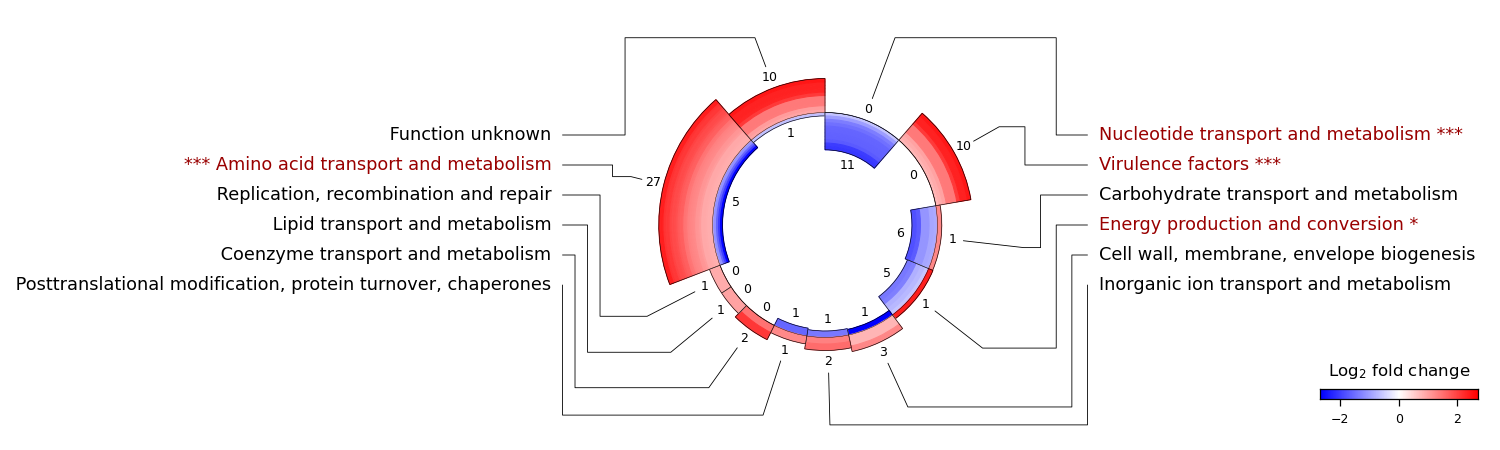

In [17]:
# Draw a pie chart depicting of fold change values
# within ontology labels found among differentiating cases.
# Make each wedge (ontology label) radial and arc dimensions
# proportional to the number of cases falling into the label.
# Draw each result as a subwedge of color proportinal to
# its fold change value. Draw the part of each wedge that
# corresponds to up-regulated cases outwards in respect
# to the scaffold circle, and the down-regulated inwards.

# Calculate the ratio of the figure dimensions.
# That is necessary to calculate ranges of axes in order
# to avoid the circular shape turning into eliptical.
ratio = fig_h/fig_w

# Create a figure and axes.
fig = plt.figure(figsize=(fig_w,fig_h), facecolor='white', dpi=150)

ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()

# Create a new DataFrame to which geometrical measures of each
# ontology wedge will be collected. These measures will be
# used to position connectors and lables:
# theta -- start radius
# r_in  -- radial width of the wegde portion directed inwards
#          the scaffold circle (log2FoldChange < 0)
# r_out -- radial width of the wegde portion directed outwards
#          the scaffold circle (log2FoldChange > 0)
# text  -- wedge label (ontology name)
# sign  -- asterisks denoting significance thresholds for
#          up-regulated transcripts
# color -- label color (red if an ontology is over-represented)
label_cols = 'theta r_in r_out text sign color'.split()
labels_df = pd.DataFrame(columns=label_cols)

# Iterate over calculated thetas, arc sizes, scaled sizes, positive fractions
# and ontology list to fill up the labels_df DataFrame, i.e. measures of wedges
# corresponding to ontologies, as well as to draw subwedges corresponding
# to cases within each ontology.
for theta, arc, size, posfrac, rawdata in zip(
    thetas, arcs, scaled, posfracs, onts_list):
    # Calculate the "real" radial width of a wedge, i.e. the actual
    # radial width of a wedge based on the scaled number of cases falling
    # into an ontology and an arbitrarily assumed scale.
    real_w = size*scale
    
    # Collect the ontology name as well as the positive and negative
    # fold change values
    ontname  = rawdata[0]
    negfolds = sorted([ abs(fold) for fold in rawdata[1] if fold <  0.0 ])
    posfolds = sorted([ fold      for fold in rawdata[1] if fold >= 0.0 ])

    # Draw subwedges. Calculate their radial span as a fraction of the real
    # radial width of a wedge. Use a colors proportinal to fold change values
    # scaled against the maximal value (max_fold). Use scale of reds for
    # up-regulated transcripts and of blues for down-regulated ones.
    for i, fold in enumerate(negfolds):
        span = real_w*(1.0-posfrac) / len(negfolds)
        color = (1.0-abs(fold)/max_fold, 1.0-abs(fold)/max_fold, 1.0)
        ax.add_patch( Wedge((0.0, 0.0), pie_r-span*i, theta, theta+arc,
                            width=span, linewidth=0.5, edgecolor=color,
                            facecolor=color) )

    for i, fold in enumerate(posfolds):
        span = real_w*posfrac / len(posfolds)
        color = (1.0, 1.0-abs(fold)/max_fold, 1.0-abs(fold)/max_fold)
        ax.add_patch( Wedge((0.0, 0.0), pie_r+span*(i+1), theta, theta+arc,
                            width=span, linewidth=0.5, edgecolor=color,
                            facecolor=color) )

    # Sketch a wedge frame around already drawn subwedges.
    ax.add_patch( Wedge((0.0, 0.0), pie_r+posfrac*real_w, theta, theta+arc,
                        width=real_w, fill=False, linewidth=0.3) )
    
    # Assigned color and optinally add asterisks to an ontology (wedge) label
    # if the ontology happens to be over-represented.
    sign, color = get_sign(*ont_df.loc[ontname, ['pval', 'trend']])

    # Recalculate degrees into radians. Add all collected and
    # calculated measures to labels_df DataFrame.
    theta_rad = (theta+0.5*arc)/180*np.pi
    labels_df.loc[ labels_df.shape[0] ] = theta_rad,      \
        pie_r-(1.0-posfrac)*real_w, pie_r+posfrac*real_w, \
        ontname, sign, color

# Sketch the scaffold circle arcross already drawn wedges.
ax.add_patch( Circle((0.0, 0.0), pie_r, fill=False, linewidth=0.2,
                     color='black') )

# Based on values from different columns from labels_df DataFrame, calculate
# coordinates of connectors fragments, number of transcript labels and
# ontology labels. Add the coordinates to labels_df DataFrame.
# numup_       -- labels for number of up-regulated transcripts,
#                 (outwards the wedges)
# numupdown_   -- labels for number of down-regulated transcripts,
#                 (inwards the wedges)
# Coordinates of connector points starting at a wedge and finishing at
# an ontology (wedge) label:
# conn_term_   -- start points at the wedge
# conn_proxy_  -- points on the outer scaffold circle
# conn_middle_ -- x and y values shared by next two middle points
# conn_init_   -- points at ontology (wedge) labels
labels_df['numup_x']   = np.cos(labels_df['theta']) *  \
                         (labels_df['r_out'] + margin)
labels_df['numup_y']   = np.sin(labels_df['theta']) *  \
                         (labels_df['r_out'] + margin)

labels_df['numdown_x'] = np.cos(labels_df['theta']) *  \
                         (labels_df['r_in'] - margin)
labels_df['numdown_y'] = np.sin(labels_df['theta']) *  \
                         (labels_df['r_in'] - margin)

labels_df['conn_term_x'] = np.cos(labels_df['theta']) *      \
                           (labels_df['r_out'] + 2.0*margin)
labels_df['conn_term_y'] = np.sin(labels_df['theta']) *      \
                           (labels_df['r_out'] + 2.0*margin)

proxy_r = labels_df['r_out'].max() + 3.0*margin

labels_df['conn_proxy_x'] = np.cos(labels_df['theta']) * (proxy_r)
labels_df['conn_proxy_y'] = np.sin(labels_df['theta']) * (proxy_r)

labels_df.sort_values('conn_proxy_y', ascending=False, inplace=True)
sub_index_left = labels_df.loc[ labels_df['conn_proxy_x'] <= 0.0 ].index
sub_index_right = labels_df.index.difference(sub_index_left, sort=False)

for sub_index in sub_index_left, sub_index_right:
    max_rank = sub_index.shape[0] // 2
    labels_df.loc[sub_index, 'rank'] = pd.Series(
        range(max_rank, max_rank-sub_index.shape[0], -1), index=sub_index)

labels_df.loc[sub_index_left, 'rank_norm'] =              \
    (labels_df.loc[sub_index_left, 'rank'] +              \
    np.abs(labels_df.loc[sub_index_left,  'rank'].min()))
labels_df.loc[sub_index_left, 'rank_norm'] =        \
    labels_df.loc[sub_index_left, 'rank_norm'] /    \
    labels_df.loc[sub_index_left,'rank_norm'].max()

labels_df.loc[sub_index_right, 'rank_norm'] =              \
    (labels_df.loc[sub_index_right, 'rank'] +              \
    np.abs(labels_df.loc[sub_index_right,  'rank'].min()))
labels_df.loc[sub_index_right, 'rank_norm'] =        \
    labels_df.loc[sub_index_right, 'rank_norm'] /    \
    labels_df.loc[sub_index_right,'rank_norm'].max()

labels_df['rank_norm'] = labels_df['rank_norm'].fillna(0.0)

labels_df['conn_init_y'] = label_height * labels_df['rank']
labels_df.loc[labels_df['conn_term_x'] <  0, 'conn_init_x'] = label_at * -1
labels_df.loc[labels_df['conn_term_x'] >= 0, 'conn_init_x'] = label_at

conn_range = label_at - proxy_r

# Upper right quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] < 0) &
    (labels_df['conn_init_y'] < labels_df['conn_proxy_y'])
].index
if sub_index.shape[0] != 0:
    step = conn_range / sub_index.shape[0]
    labels_df.loc[sub_index, 'conn_middle_x'] = -1* proxy_r - \
        step * np.arange(sub_index.shape[0]-1, -1, -1)

# Upper left quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] > 0) &
    (labels_df['conn_init_y'] < labels_df['conn_proxy_y'])
].index
if sub_index.shape[0] != 0:
    step = conn_range / sub_index.shape[0]
    labels_df.loc[sub_index, 'conn_middle_x'] = proxy_r + \
        step * np.arange(sub_index.shape[0]-1, -1, -1)

# Lower right quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] < 0) &
    (labels_df['conn_init_y'] > labels_df['conn_proxy_y'])
].index
if sub_index.shape[0] != 0:
    step = conn_range / sub_index.shape[0]
    labels_df.loc[sub_index, 'conn_middle_x'] = -proxy_r - \
        step * np.arange(1, sub_index.shape[0]+1, 1)

# Lower left quarter labels (if x-axis reveresed, default).
sub_index = labels_df[
    (labels_df['conn_init_x'] > 0) &
    (labels_df['conn_init_y'] > labels_df['conn_proxy_y'])
].index
if sub_index.shape[0] != 0:
    step = conn_range / sub_index.shape[0]
    labels_df.loc[sub_index, 'conn_middle_x'] = proxy_r + \
        step * np.arange(1, sub_index.shape[0]+1, 1)

# Iterate over labels_df DataFrame and based on alread calculated
# geometric measures draw connectors and labels.
for i, row in labels_df.iterrows():
    x, y = row['numup_x'], row['numup_y']
    ax.text(x, y, ont_df.loc[row['text'], 'upreg_cases'],
            va='center', ha='center', fontsize=num_font)

    x, y = row['numdown_x'], row['numdown_y']
    ax.text(x, y, ont_df.loc[row['text'], 'downreg_cases'],
            va='center', ha='center', fontsize=num_font)
    
    X = row['conn_init_x conn_middle_x conn_middle_x'.split() +
            'conn_proxy_x conn_term_x'.split()]
    Y = row['conn_init_y conn_init_y conn_proxy_y'.split() +
            'conn_proxy_y conn_term_y'.split()]
    ax.plot(X, Y, linewidth=0.4, color='black', solid_joinstyle='round',
            solid_capstyle='round')

    x, y, text, sign, color = \
        row['conn_init_x conn_init_y text sign color'.split()]
    if x < 0:
        x -= margin
        label = f'{text} {sign}'
        ha    = 'left'
    else:
        x += margin
        label = f'{sign} {text}'
        ha    = 'right'
    ax.text(x, y, label, va='center', ha=ha, color=color, fontsize=label_font)

# Draw the log2FoldChange scale bar (heatmap) on separate axes, assuming
# arbitrary number of cells (color bands) and their widths (sizes).
bar_cell_size  = 0.05
bar_cell_count = 7
ax_bar = fig.add_axes([0.88, 0.1, bar_cell_size*ratio*bar_cell_count,
                       bar_cell_size])
ax_bar.set_yticks([])
for spine in ['left', 'top', 'right', 'bottom']:
    ax_bar.spines[spine].set_linewidth(0.6)
ax_bar.tick_params(width=0.6, labelsize=6.0)
steps  = np.linspace(0.0, 1.0, 50)
colors = np.stack([steps, steps, np.ones(steps.shape[0])], axis=1)
steps  = np.linspace(1.0, 0.0, 50)[1:]
colors = np.vstack([colors, np.stack([np.ones(steps.shape[0]), steps, steps],
                    axis=1)])
ax_bar.imshow(
    colors.reshape((1,99,3)),
    extent = (-max_fold, max_fold, 0, max_fold/(bar_cell_count + 1))
)
ax_bar.set_title(scale_bar_label, fontsize=sbar_font)

# Set x-axis limits. Based on figure
# fig_h/fig_w ratio, calculate y-axis limits.
xrange = np.abs(xmax - xmin)
xmin_p = -xrange - xmin
xmax_p =  xrange - xmax
ax.set_xlim(xmax_p, xmin_p)
ax.set_ylim(-xrange/2*ratio, xrange/2*ratio)

# Save the figure.
fig.savefig(chart_file, transparent=False, dpi=dpi)
Image.open(chart_file).convert('RGB').save(chart_file)